In [1]:
import sys; sys.path.insert(0, '..')
import utils
import keras
import numpy as np

def embed_and_translate(data, n_width, n_height):
    ndata = np.zeros((len(data), n_width, n_height, 1), dtype='float32')
    translations = np.empty((len(data), 2), dtype='float32')
    width, height = data.shape[1], data.shape[2]
    for i in range(len(data)):
        x = np.random.randint(n_width-width)
        y = np.random.randint(n_height-height)
        ndata[i][x:x+width, y:y+height] = data[i] # rows, cols = height, width
        translations[i][0] = x+(width//2)
        translations[i][1] = y+(height//2)
    return ndata, translations
            
n_splits = 16
output_shape = (56, 56, 1)
input_shape  = (14, 14, 1)
split_x, split_y = 14, 14
latent_dim = 4

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_augmented, y_train_regr = embed_and_translate(x_train, output_shape[0], output_shape[1])
x_train_split = np.array([utils.split(x, split_x, split_y) for x in x_train_augmented], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_augmented, y_test_regr = embed_and_translate(x_test, output_shape[0], output_shape[1])
x_test_split = np.array([utils.split(x, split_x, split_y) for x in x_test_augmented], dtype='float32')
y_test = keras.utils.to_categorical(y_test)

In [2]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout, MaxPooling2D
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, input_shape, output_shape):
        super(MultiSplit, self).__init__()
        self.encoder = self._create_encoder(latent_dim, input_shape)
        self.input_reshaper = utils.Reshaper((n_splits, *input_shape), input_shape)
        self.latent_reshaper = utils.Reshaper([latent_dim], [n_splits * latent_dim])
        self.decoder = self._create_decoder(n_splits * latent_dim, output_shape)
        self.classifier = self._create_classifier(n_splits * latent_dim)
        self.regressor = self._create_regressor(n_splits * latent_dim)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
        y_reco = self.decode(z ,training=training)
        y_class = self.classify(z ,training=training)
        y_regr = self.regress(z ,training=training)
        return {"decoder_out": y_reco, "classifier_out": y_class, "regressor_out": y_regr}
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def regress(self, z, training=True):
        return self.regressor( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
            Dense(units=latent_dim, activation='sigmoid')
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[1]//4 * 8),  #! Reduce amount of neurons by 4.
            Reshape((io_shape[0]//4, io_shape[1]//4, 8)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax', name='classifier_out')
        ])
    
    def _create_regressor(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='relu'),
            Dense(2, activation='linear', name='regressor_out')
        ])

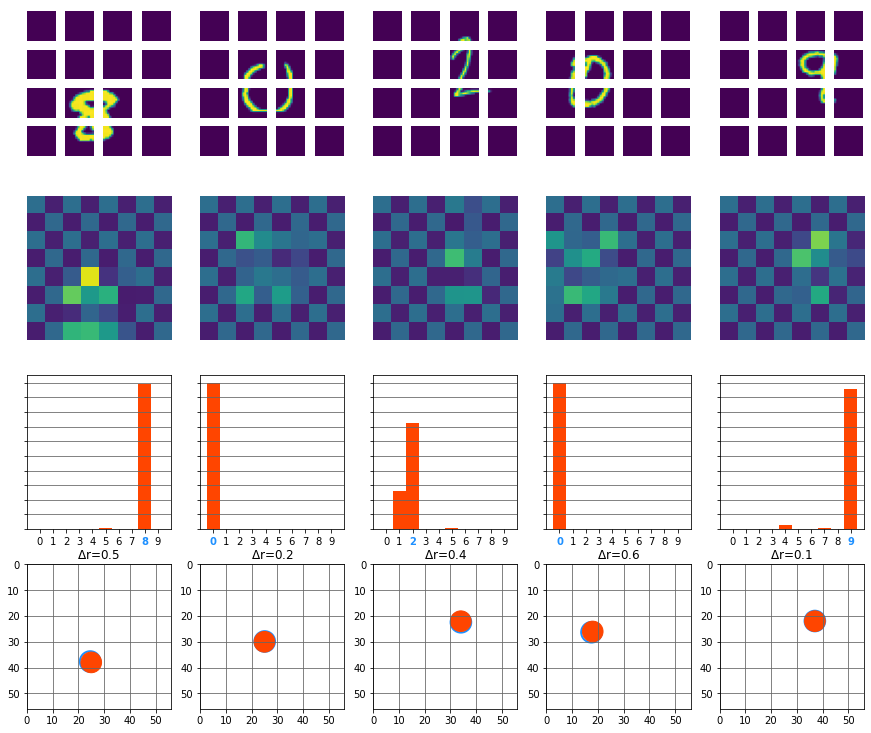

In [10]:
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from matplotlib.patches import Circle

model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
model.load_weights('../weights/43_CAE4x16_regr+class_epoch50_weights.h5')

n = 5
# n = 3
plt.figure(figsize=(15, 13))
yticks = True
ax0, ax1 = None, None
axs=[]
for i in range(n):
    
    r = random.randint(0, 1000)
    x = x_test_split[r].reshape(1,16,14,14,1)
    z = model.encode(x, training=False)
    
    y = model.classify(z, training=False)
    truth = np.argmax(y_test[r])
    
    y_regr = model.regress(z, training=False)
    
    y_t, y_pred = (y_regr[0][1], y_regr[0][0]), (y_test_regr[r][1], y_test_regr[r][0])

    a = np.empty((56,56))
    ax = plt.subplot(4, n, i+1)
    for j in range(16):
        r = int(j/4)
        c = j%4
        ins = ax.inset_axes([0.0+c*0.265,0.75-r*0.25,0.20,0.25])
        ins.axis('off')
        ins.imshow(tf.reshape(x[0][j], (14, 14)), vmin=0, vmax=1)
    ax.axis('off')
    axs.append(ax)
    
    a = np.empty((8,8))
    for j in range(16):
        r = int(j/4)
        c = j%4
        a[r*2:(r+1)*2, c*2:(c+1)*2] = tf.reshape(z[j], (2,2))
    ax = plt.subplot(4, n, n+i+1) 
    plt.axis('off')
    plt.imshow(a, vmin=0, vmax=1)
    axs.append(ax)
    
    ax0 = plt.subplot(4, n, 2*n+i+1, sharey=ax0)
    plt.bar(range(10), y[0], width=1, color='orangered')
#     plt.bar(range(10), y[0], width=1)
    plt.setp(ax0.get_yticklabels(), visible=yticks)
    plt.xticks(np.arange(0,10,step=1))
    plt.yticks(np.arange(0,1.1,step=.1))
    yticks = False
    plt.grid(b=True, axis='y', which='both', color='#666666', linestyle='-')
    plt.gca().get_xticklabels()[truth].set_color('dodgerblue')
    plt.gca().get_xticklabels()[truth].set_weight('bold')
    axs.append(ax0)
    
    ax1 = plt.subplot(4, n, 3*n+i+1, sharey=ax1)
    plt.axis('on')
    plt.setp(ax0.get_yticklabels(), visible=yticks)
    plt.xticks(np.arange(0, 60, step=10))
    plt.yticks(np.arange(0, 60, step=10))
    plt.xlim((0, 56))
    plt.ylim((56, 0))
    yticks = False
#     plt.title("est. {:3.1f}, {:3.1f}\ntru. {:3.1f}, {:3.1f}".format(y[0][1], y[0][0], y_test_regr[r][1], y_test_regr[r][0]))
    dist = ((y_t[0]-y_pred[0])**2+(y_t[1]-y_pred[1])**2)**(1/2)
    plt.title("$\Delta$r={:1.1f}".format(dist))
    circ = Circle((y_t[0], y_t[1]),radius=4, edgecolor='dodgerblue', linewidth=2, fill=False)
    circ2 = Circle((y_pred[0], y_pred[1]),radius=4, color='orangered')
    ax1.add_patch(circ)
    ax1.add_patch(circ2)
    plt.imshow(np.ones((56,56)), cmap='binary')
    plt.grid(b=True, axis='both', which='both', color='#666666', linestyle='-')
    
# plt.colorbar(ax=axs)
plt.savefig('../img/57_PLOTS/16split_classif_regre_expl6.png', dpi=200)